### Code by Lauren Hayward Sierens and Juan Carrasquilla
### This code builds a simple data set of spirals with K branches and then implements and trains a simple feedforward neural network to classify its branches.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
#Specify font sizes for plots:
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

seed=1234
np.random.seed(seed)
tf.set_random_seed(seed)

plt.ion() # turn on interactive mode (for plotting)

In [6]:
N = 50 # number of points per branch
K = 3  # number of branches

N_train = N*K # total number of points in the training set
x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
y_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)


mag_noise = 0.3  # controls how much noise gets added to the data
dTheta    = 4    # difference in theta in each branch

# Data generation:

In [7]:
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.01,1,N) # radius
  t = np.linspace(j*(2*np.pi)/K, j*(2*np.pi)/K + dTheta, N) + np.random.randn(N)*mag_noise # theta
  x_train[ix] = np.c_[r*np.cos(t), r*np.sin(t)]
  y_train[ix] = j

In [8]:
x_train.shape, y_train.shape

((150, 2), (150,))

# Plot the data set:

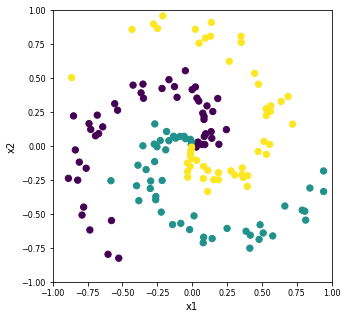

In [8]:
fig = plt.figure(1, figsize=(5,5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40)#, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('x1')
plt.ylabel('x2')
fig.savefig('spiral_data.pdf')

# DEFINE THE NETWORK ARCHITECTURE

In [22]:
# Create placeholders for the input data and labels #
# (we'll input actual values when we ask TensorFlow to run an actual computation later) #
x = tf.placeholder(tf.float32, [None, 2]) # input data
y = tf.placeholder(tf.int32,[None])       # labels

# Layer 1: #
W1 = tf.Variable( tf.random_normal([2, 4], mean=0.0, stddev=0.01, dtype=tf.float32) )
b1 = tf.Variable( tf.zeros([4]) )
z1 = tf.matmul(x, W1) + b1
a1 = tf.nn.sigmoid( z1 )

# Layer 2: #
W2 = tf.Variable( tf.random_normal([4, K], mean=0.0, stddev=0.01, dtype=tf.float32) )
b2 = tf.Variable( tf.zeros([K]) )
z2 = tf.matmul(a1, W2) + b2
a2 = tf.nn.sigmoid( z2 )

# Network output: #
aL = a2

# Cost function: #
# (measures how far off our model is from the labels) #
y_onehot = tf.one_hot(y,depth=K) # labels are converted to one-hot representation
eps=0.0000000001 # to prevent the logs from diverging
cross_entropy = tf.reduce_mean(-tf.reduce_sum( y_onehot * tf.log(aL+eps) +  (1.0-y_onehot )*tf.log(1.0-aL +eps) , reduction_indices=[1]))
#mse = tf.reduce_mean(tf.reduce_sum(tf.square(y_onehot - aL)))
cost_func = cross_entropy
#cost_func = mse

# Use backpropagation to minimize the cost function using the gradient descent algorithm: #
learning_rate  = 0.3 # hyperparameter
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_func)

N_epochs = 20000 # number of times to run gradient descent



# Function for plotting

In [16]:
############ Function for plotting: ############
def updatePlot():

    ### Generate coordinates covering the whole plane: ###
    padding = 0.1
    spacing = 0.02
    x1_min, x1_max = x_train[:, 0].min() - padding, x_train[:, 0].max() + padding
    x2_min, x2_max = x_train[:, 1].min() - padding, x_train[:, 1].max() + padding
    x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, spacing),
                         np.arange(x2_min, x2_max, spacing))

    NN_output       = sess.run(aL,feed_dict={x:np.c_[x1_grid.ravel(), x2_grid.ravel()]})
    predicted_class = np.argmax(NN_output, axis=1)

    ### Plot the classifier: ###
    plt.subplot(121)
    plt.contourf(x1_grid, x2_grid, predicted_class.reshape(x1_grid.shape), K, alpha=0.8)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=40)
    plt.xlim(x1_grid.min(), x1_grid.max())
    plt.ylim(x2_grid.min(), x2_grid.max())
    plt.xlabel('x1')
    plt.ylabel('x2')

    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

# TRAINING

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epoch_list    = []
cost_training = []
acc_training  = []

In [24]:
### Train for several epochs: ###
for epoch in range(N_epochs):
    sess.run(train_step, feed_dict={x: x_train,y:y_train}) #run gradient descent
    
    ### Update the plot and print results every 500 epochs: ###
    if epoch % 500 == 0:
        cost = sess.run(cost_func,feed_dict={x:x_train, y:y_train})
        NN_output = sess.run(aL,feed_dict={x:x_train, y:y_train})
        predicted_class = np.argmax(NN_output, axis=1)
        accuracy = np.mean(predicted_class == y_train)
    
        print( "Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy) )
    
        epoch_list.append(epoch)
        cost_training.append(cost)
        acc_training.append(accuracy)
        
        ### Update the plot of the resulting classifier: ###
        #fig = plt.figure(2,figsize=(10,5))
        #fig.subplots_adjust(hspace=.3,wspace=.3)
        #plt.clf()
        #updatePlot()
        #plt.pause(0.1)

#plt.savefig('spiral_results.pdf') # Save the figure showing the results in the current directory

#plt.show()


Iteration 0:
  Training cost 2.030011
  Training accuracy 0.333333

Iteration 500:
  Training cost 1.798671
  Training accuracy 0.466667

Iteration 1000:
  Training cost 1.464449
  Training accuracy 0.493333

Iteration 1500:
  Training cost 1.428411
  Training accuracy 0.500000

Iteration 2000:
  Training cost 1.388407
  Training accuracy 0.493333

Iteration 2500:
  Training cost 1.289634
  Training accuracy 0.653333

Iteration 3000:
  Training cost 1.155037
  Training accuracy 0.726667

Iteration 3500:
  Training cost 1.069726
  Training accuracy 0.746667

Iteration 4000:
  Training cost 1.011840
  Training accuracy 0.766667

Iteration 4500:
  Training cost 0.964859
  Training accuracy 0.766667

Iteration 5000:
  Training cost 0.928527
  Training accuracy 0.780000

Iteration 5500:
  Training cost 0.903965
  Training accuracy 0.793333

Iteration 6000:
  Training cost 0.888257
  Training accuracy 0.813333

Iteration 6500:
  Training cost 0.877939
  Training accuracy 0.820000

Iteration 